## Problem 1b: 
## Fixed flux spinodal decomposition on a square domain
## (new equation for f_chem)

Necessary imports for graphing and PDE solving:

In [36]:
%matplotlib inline
import fipy as fp
import numpy as np
import matplotlib.pyplot as plt

For this problem, we choose $f_{chem}$ or $f_0$ to have the simple polynomial form, $$ f_0  = \varrho_s(c-c_{\alpha})^2(c_{\beta}-c)^2.$$ Constants are defined below.
We start by calculating $f_{0var}=\frac{\partial^2 f_0}{\partial t^2}$ using sympy:

In [37]:
import sympy
A, c, c_m, B, c_alpha, c_beta, rho_s = sympy.symbols("A c_var c_m B c_alpha c_beta rho_s")
f_0 = rho_s*((c - c_alpha)**2)*((c_beta-c)**2)

print sympy.diff(f_0, c, 2)

2*rho_s*((c_alpha - c_var)**2 + 4*(c_alpha - c_var)*(c_beta - c_var) + (c_beta - c_var)**2)


The square domain of the problem has dimensions 20 units by 20 units, with cells that are half a unit long on each side. A Grid2D object is used because the domain's boundary conditions are fixed (no flux).

In [38]:
mesh = fp.Grid2D(nx=50, ny=50, dx=0.5, dy=0.5)

Constants and initial conditions:
$c_{\alpha}, c_{\beta},$ and $c_m = \frac{(c_{\alpha} + c_{\beta})}{2}$ are concentrations at which the bulk free energy has minima.
$\kappa$ is the gradient energy coefficient.
$\varrho_s$ controls the height of the double-well barrier.

In [39]:
c_alpha = 0.30
c_beta = 0.70
kappa = 2.0
rho_s = 5.0
M = 5.0
# initial conditions
c_0 = 0.45
q = np.sqrt((2., 3.))
epsilon = 0.01

$c_{var}$ is a cell variable specifying concentrations at various points in the mesh. Here, it is the solution variable:

$c_{var}\left(\vec{r}, t\right)$ such that

$$ c_{var}\left(\vec{r}, 0\right) = \bar{c}_0 + \epsilon \cos \left( \vec{q} \cdot \vec{r} \right) $$

In [40]:
# array of sample c-values: used in f versus c plot
vals = np.linspace(-.1, 1.1, 1000)

c_var = fp.CellVariable(mesh=mesh, name=r"$c$", hasOld=True)
r = np.array((mesh.x, mesh.y))
c_var[:] = c_0 + epsilon * np.cos((q[:, None] * r).sum(0))
# viewer = fp.Viewer(c_var, limits = {'ymin': 0, 'ymax': 20},
#                     datamin=.440, datamax =.460,
#                     title = "Matplot2DViewer test")

The equation for the bulk free energy density (alternatively called the chemical free energy density) of this system is expressed as 
$$ \int\limits_V{\!\Big(f_{chem}+\frac{\kappa}{2}{\big|\nabla c\big|}^2}\Big)\,\mathrm{d}V.$$ 

In [41]:
(np.array(c_var))
print(c_var.grad)


[[ 0.01073054 -0.01295412 -0.01049862 ...,  0.01116697  0.01280422
  -0.01169724]
 [ 0.00918288  0.00048035 -0.00845251 ...,  0.00742378 -0.00174462
  -0.01007646]]


In [42]:
# import sympy
# import fipy as fp
# import numpy as np
# A, c, c_m, B, c_alpha, c_beta, rho_s = sympy.symbols("A c_var c_m B c_alpha c_beta rho_s")
# f_0 = rho_s*((c - c_alpha)**2)*((c_beta-c)**2)
# # def f_0(c):rho_s*((c - c_alpha)**2)*((c_beta-c)**2)
# #     return rho_s*((c - c_alpha)**2)*((c_beta-c)**2)

# print sympy.diff(f_0, c, 2)
# # def f_0_var(c_var):
    
# #     return -A + 3*B*(c_var - c_m)**2 + 3*c_alpha*(c_var - c_alpha)**2 + 3*c_beta*(c_var - c_beta)**2

In [43]:
# bulk free energy density
def f_0(c):
    return rho_s*((c - c_alpha)**2)*((c_beta-c)**2)
def f_0_var(c_var):
    return 2*rho_s*((c_alpha - c_var)**2 + 4*(c_alpha - c_var)*(c_beta - c_var) + (c_beta - c_var)**2)
# free energy
def f(c):
    return (f_0(c)+ .5*kappa*(c.grad.mag)**2)

# plot free energy density versus c
def plotf_c():
    plt.figure(1)
    plt.xlabel('c')
    plt.ylabel('f_0')
    plt.plot(vals, f_0(vals))
    plt.show()

Here, the elapsed time and total free energy at each time step are saved to separate lists. These lists are then updated in a text file.

In [44]:
# save elapsed time and free energy at each data point
f_data = []
time_data = []

def save_data(f, time):
    f_data.append(f.value)
    time_data.append(time)
    np.savetxt('1b_new_free_energy.txt', zip(time_data, f_data))

The solver equation is now defined.

In [45]:
# start solver
eqn = fp.TransientTerm(coeff=1.) == fp.DiffusionTerm(M * f_0_var(c_var)) - fp.DiffusionTerm((M, kappa))

A time stepping scheme is used to solve the equation. If the residual increases, the solver backtracks; if the specified tolerance is not reached, the time step is recalculated.

In [52]:
elapsed = 0.0
steps = 0
dt = 0.01
total_sweeps = 2
tolerance = 1e-1
total_steps = 1000

In [47]:
c_var.updateOld()
from fipy.solvers.pysparse import LinearLUSolver as Solver
solver = Solver()

Initialize an empty list for generated viewers:

In [48]:
viewers = []

100
34.0415588014
200
56.6581428656
300
81.8725840202
400
106.507201827
500
126.404778374
600
146.491451563
700
166.543646327
800
186.607950208
900
206.638588009
1000
226.724585246


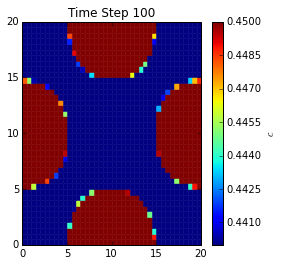

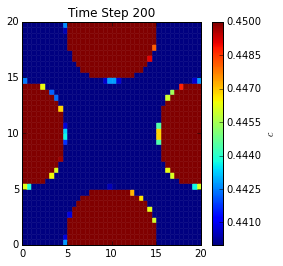

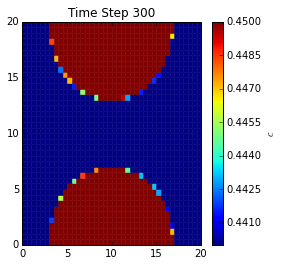

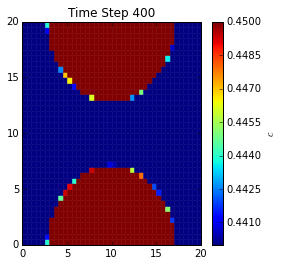

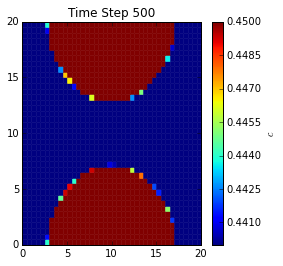

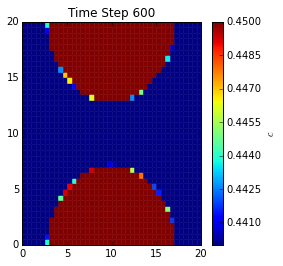

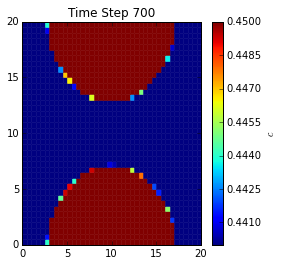

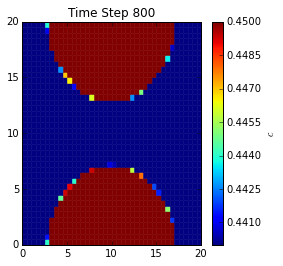

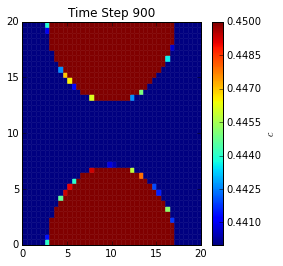

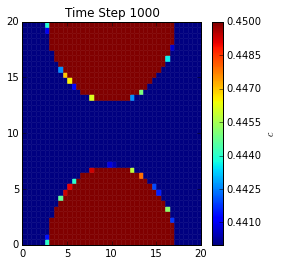

In [53]:
while steps < total_steps:
    res0 = eqn.sweep(c_var, dt=dt, solver=solver)
            
    for sweeps in range(total_sweeps):
        res = eqn.sweep(c_var, dt=dt, solver=solver)
        
#         print 'steps',steps
#         print 'res',res
#         print 'sweeps',sweeps
#         print 'dt',dt
        
    if res < res0 * tolerance:
        steps += 1
        elapsed += dt
        dt *= 1.1
        
# create 10 viewers to snapshot steps in the simulation
        if (steps%(total_steps/10)==0):
            print steps
            print elapsed
            # record the volume integral of the free energy 
            save_data(f_0_var(c_var).cellVolumeAverage*mesh.numberOfCells, elapsed)
            # pickle the data on c as a function of space at this particular time
            fp.dump.write({'time' : steps, 'var': c_var}, '{0}{1}{2}'.format("1b_new", steps, ".pkl"))
            # create a viewer based on the pickled data
            viewers.append(fp.Viewer((fp.dump.read('{0}{1}{2}'.format("1b_new", steps, ".pkl"))['var']),
                        limits = {'ymin': 0.0, 'ymax': 20.0},
                        datamin=.44, datamax =.45,
                        title = '{0}{1}'.format("Time Step ", steps)))
        
        c_var.updateOld()
    else:
        dt *= 0.8
        c_var[:] = c_var.old

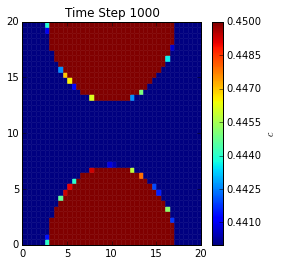

In [54]:
fp.MultiViewer(viewers).plot()

In [16]:
?fp.dump.write


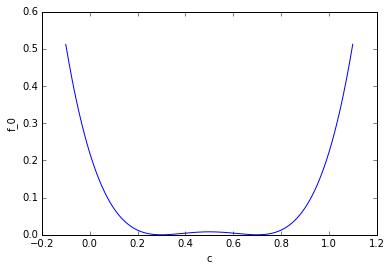

In [17]:
plotf_c()

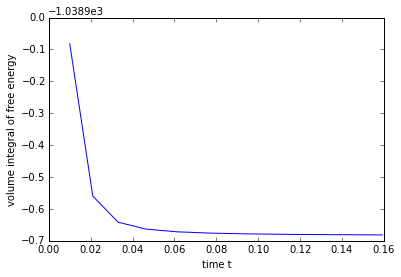

In [18]:
plt.figure(3)
plt.xlabel('time t')
plt.ylabel('volume integral of free energy')
plt.plot(time_data, f_data)
plt.show()